<a href="https://colab.research.google.com/github/samyzaf/notebooks/blob/main/bsm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Black--Scholes--Merton Formula
Author:
[Antoni Smolski](https://antonismolski.medium.com/?source=post_page-----965fd0539808--------------------------------)

Blog:
https://antonismolski.medium.com/implementation-of-black-scholes-formula-using-finite-difference-method-with-code-965fd0539808

Added comments and tweaks by Samy Zafrany.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

The implementation is the straightforward implementation of VBA code from "Paul Wilmott on Quantitative Finance". I highly reccomend this book for more details.

In [2]:
NoTimeSteps = 100
NoAssetSteps = 50
Expiry = 1.0
TimeStep = Expiry / NoTimeSteps

In [3]:
def option_value_3d(vol, int_rate, p_type, strike, expiration, NAS):
    S = np.zeros(NAS + 1)  # NAS = Number of Asset steps array
    dS = 3 * strike / NAS  # 'Infinity' is trice the strike
    dt = 0.9 / vol ** 2 / NAS ** 2  # For stability
    NTS = int(expiration / dt) + 1  # Number of time steps
    dt = expiration / NTS  # To ensure that expiration is an integer number of time steps away
    V = np.zeros((NAS + 1, NTS + 1))  # Option value array
    q = 1
    if p_type == "put":
        q = -1

    for i in range(NAS + 1):
        # ds is asset step e.g. ticks
        S[i] = i * dS
        # Payoff function
        # sets values at time t_0 based on the set up asset prices
        V[i, 0] = max(q * (S[i] - strike), 0)

    for k in range(1, NTS + 1):  # Time loop
        ## And now ta dam ... Nobel prize winning diff equation ;)
        for i in range(1, NAS):  # Asset loop
            delta = (V[i+1, k-1] - V[i-1, k-1]) / (2*dS)                 # Central difference
            gamma = (V[i+1, k-1] - 2*V[i, k-1] + V[i-1, k-1]) / (dS**2)  # Central difference
            # Black-Scholes:
            theta = -0.5 * vol ** 2 * S[i] ** 2 * gamma - int_rate * S[i] * delta + int_rate * V[i, k - 1]
            V[i, k] = V[i, k - 1] - dt * theta

        V[0, k] = V[0, k - 1] * (1 - int_rate * dt)    # Boundary condition at S=0
        V[NAS, k] = 2 * V[NAS - 1, k] - V[NAS - 2, k]  # Boundary condition at S=infinity

    asset_range = np.arange(0, NAS + 1) * dS  # Asset price range
    time_steps = np.arange(0, NTS + 1) * dt
    rounded_time_steps = np.round(time_steps, decimals=3)
    df = pd.DataFrame(V, index=asset_range, columns=rounded_time_steps).round(3)

    return df  # Output array


In [4]:
sigma = 0.2
r = 0.05
K = 100
T = 1
NAS = 20 # number of asset steps

option_df = option_value_3d(sigma, r, "call", K, T, NAS)

In [5]:
option_df.tail()

,0.000,0.056,0.111,0.167,0.222,0.278,0.333,0.389,0.444,0.500,0.556,0.611,0.667,0.722,0.778,0.833,0.889,0.944,1.000
240.0,140.0,140.278,140.555,140.831,141.106,141.381,141.655,141.928,142.201,142.472,142.743,143.013,143.283,143.552,143.819,144.087,144.353,144.619,144.884
255.0,155.0,155.278,155.555,155.831,156.106,156.381,156.655,156.928,157.201,157.472,157.743,158.013,158.283,158.552,158.819,159.087,159.353,159.619,159.884
270.0,170.0,170.278,170.555,170.831,171.106,171.381,171.655,171.928,172.201,172.472,172.743,173.013,173.283,173.552,173.819,174.087,174.353,174.619,174.884
285.0,185.0,185.278,185.555,185.831,186.106,186.381,186.655,186.928,187.201,187.472,187.743,188.013,188.283,188.552,188.819,189.087,189.353,189.619,189.884
300.0,200.0,200.278,200.555,200.831,201.106,201.381,201.655,201.928,202.201,202.472,202.743,203.013,203.283,203.552,203.819,204.087,204.353,204.619,204.884


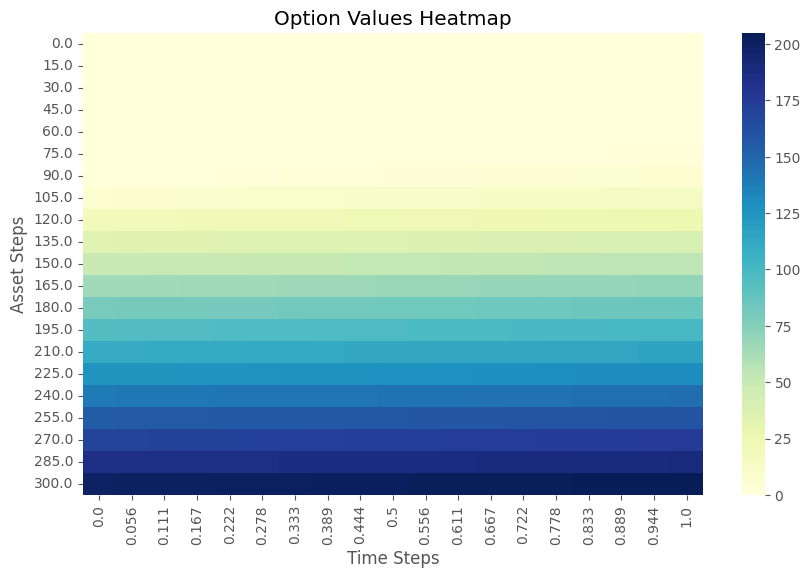

In [6]:
plt.figure(figsize=(10, 6))
sns.heatmap(option_df, cmap='YlGnBu', fmt=".3f")
plt.title('Option Values Heatmap')
plt.xlabel('Time Steps')
plt.ylabel('Asset Steps')
plt.show()

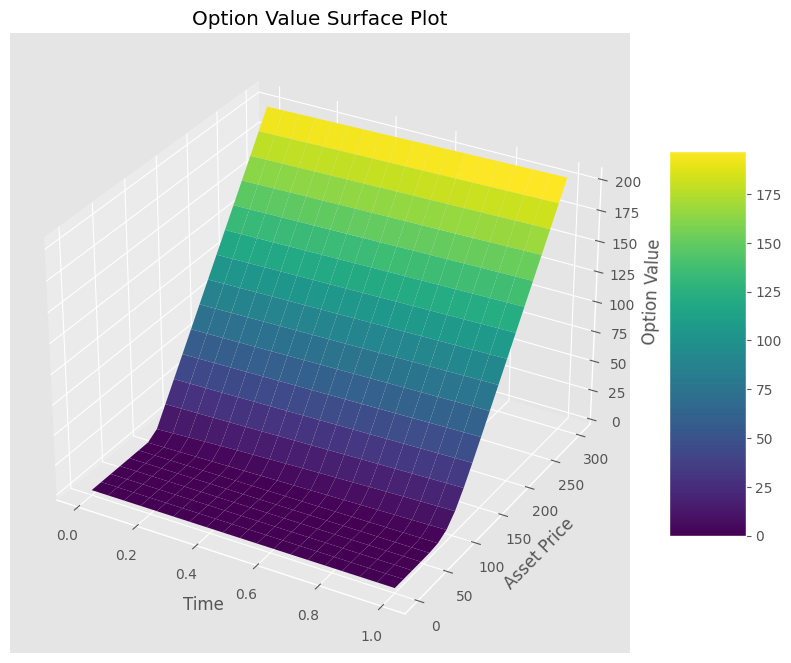

In [7]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

X, Y = np.meshgrid(option_df.columns, option_df.index)
Z = option_df.values

surf = ax.plot_surface(X, Y, Z, cmap='viridis')

ax.set_xlabel('Time')
ax.set_ylabel('Asset Price')
ax.set_zlabel('Option Value')
ax.set_title('Option Value Surface Plot')

fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

## American Options

The change in the case of the American option is straightforward. We just have to compare if the immediate exercise of the option is more profitable than holding it. So, if the option value is below the intrinsic. Don't mistake it for the market value. If the option with our model is worth 10 and the market value is 1000, then you should not exercise. You just basically sell it to someone else.

In [ ]:
def option_value_3d_with_exercise(vol, int_rate, p_type, strike, expiration, NAS):
    dS = 2 * strike / NAS
    dt = 0.9 / vol ** 2 / NAS ** 2
    NTS = int(expiration / dt) + 1
    dt = expiration / NTS
    V = np.zeros((NAS + 1, NTS + 1))
    q = 1
    S = np.zeros(NAS + 1)

    q = 1 if p_type == "C" else -1

    Payoff = np.zeros(NAS + 1)

    for i in range(NAS + 1):
        S[i] = i * dS
        V[i, 0] = max(q * (S[i] - strike), 0)
        Payoff[i] = V[i, 0]

    locations = []
    for k in range(1, NTS + 1):  # Time loop
        for i in range(1, NAS):  # Asset loop
            delta = (V[i + 1, k - 1] - V[i - 1, k - 1]) / 2 / dS  # Central difference
            gamma = (V[i + 1, k - 1] - 2 * V[i, k - 1] + V[i - 1, k - 1]) / dS / dS  # Central difference
            theta = -0.5 * vol ** 2 * S[i] ** 2 * gamma - int_rate * S[i] * delta + int_rate * V[i, k - 1]  # Black-Scholes
            V[i, k] = V[i, k - 1] - dt * theta

            discounted_payoff = Payoff[i] * np.exp(-int_rate * k* dt)
            #print(discounted_payoff)

            if discounted_payoff > V[i, k]:
                locations.append((i, k))

            # Our modification
            V[i, k] = np.maximum(V[i, k], discounted_payoff)

        V[0, k] = V[0, k - 1] * (1 - int_rate * dt)  # Boundary condition at S=0
        V[NAS, k] = 2 * V[NAS - 1, k] - V[NAS - 2, k]  # Boundary condition at S=infinity

    asset_range = np.arange(0, NAS + 1) * dS
    time_steps = np.arange(0, NTS + 1) * dt
    rounded_time_steps = np.round(time_steps, decimals=3)
    df = pd.DataFrame(V, index=asset_range, columns=rounded_time_steps).round(3)

    return df, locations

In [ ]:
sigma = 0.2
r = 0.05
K = 100
T = 1
NAS = 100

option_dfs, locations  = option_value_3d_with_exercise(sigma, r, "call", K, T, NAS)

In [ ]:
option_dfs

,0.000,0.002,0.004,0.007,0.009,0.011,0.013,0.016,0.018,0.020,...,0.980,0.982,0.984,0.987,0.989,0.991,0.993,0.996,0.998,1.000
0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
6.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
8.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192.000,92.000,92.011,92.022,92.034,92.045,92.056,92.067,92.079,92.090,92.101,...,96.782,96.793,96.803,96.814,96.825,96.835,96.846,96.857,96.868,96.878
194.000,94.000,94.011,94.022,94.034,94.045,94.056,94.067,94.079,94.090,94.101,...,98.782,98.792,98.803,98.814,98.824,98.835,98.846,98.856,98.867,98.878
196.000,96.000,96.011,96.022,96.034,96.045,96.056,96.067,96.079,96.090,96.101,...,100.781,100.792,100.803,100.813,100.824,100.835,100.845,100.856,100.867,100.877
198.000,98.000,98.011,98.022,98.034,98.045,98.056,98.067,98.079,98.090,98.101,...,102.781,102.792,102.802,102.813,102.824,102.834,102.845,102.856,102.866,102.877
